In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from myDataSet_v2 import *
from myNetworks_v2 import *
from tqdm import tqdm

In [2]:

def test_model(trained_model: NeuralNet | NeuralNet2,
               data: DataPrep,
               nr_batches: int = 0,
               verbose: bool = False) -> None:
    """
    Void type function that tests a trained model on 'nr_batches' randomly
    selected batches by comparing model prediction with actual label.

     Parameters:
    - trained_model: the trained Neural Net.
    - data: that data to test model on.
    - nr_batches: the nr. of batches to test on.
    - verbose: boolean determining whether to print progress.

    """

    assert nr_batches <= len(data.Y), f'Requested nr. batches is larger than nr. batches available in data.'

    # Defaulting to all batches
    if nr_batches == 0:
        print("Testing model on all available test batches..")
        rand_indices = [i for i in range(len(data.validation_Y))]
    else:
        # Generating random indices
        rand_indices = []
        while len(rand_indices) < nr_batches:
            _rand_int = torch.randint(low=0, high=len(data.validation_Y), size=(1,)).item()
            if _rand_int not in rand_indices:
                rand_indices.append(_rand_int)

    # Predicting w. model and checking against true labels
    batch_counter = 0
    correct_counter = 0
    with torch.no_grad():
        for _index in rand_indices:
            mod = trained_model.forward(data.validation_X[_index])
            y_hat = trained_model.predict(mod)
            y_real = data.validation_Y[_index]
            if verbose:
                print("\n ---  Random Batch: ", batch_counter + 1, " ---")
            for _data_point in range(y_hat.shape[0]):
                pred = list(data.label_dict.keys())[torch.where(y_hat[_data_point] == 1)[0]]
                actual = list(data.label_dict.keys())[torch.where(y_real[_data_point] == 1)[0]]
                if verbose:
                    print("  ##| Prediction: ", pred, " |--| Actual: ", actual, " |##")
                if pred == actual:
                    correct_counter += 1
            batch_counter += 1
    print("\n #####| ", correct_counter, "/", batch_counter * data.batch_size, " items in ", len(rand_indices), " test batches predicted correctly ~ acc: ", round(correct_counter / (batch_counter * data.batch_size), 4), " |#####")



In [3]:
# Setting up the dataset and dataloaders
image_directory = "Insects"
annotations_file_directory = "insects.csv"
image_dims = (520,520)
my_transform = torchvision.transforms.Resize(image_dims)
full_dataset = MyCustomImageDataset2(annotations_file_dir=annotations_file_directory,
                               image_directory_path=image_directory,
                               transform=my_transform)

# Fraction of available data to consider
data_fraction = 0.05

init_full_len = full_dataset.__len__()
data_len = int(init_full_len*data_fraction)
_ , full_dataset = torch.utils.data.random_split(dataset=full_dataset,
                                                 lengths=(init_full_len-data_len,data_len))

# Splitting into training, test and validation sets
test_fraction = 0.2
validation_fraction = 0.2

full_len = full_dataset.__len__()
test_len = int(test_fraction*full_len)
remaining_len = full_len - test_len
validation_len = int(validation_fraction * remaining_len)

my_lengths = (full_len - test_len - validation_len, validation_len, test_len)
train_set, validation_set, test_set =  torch.utils.data.random_split(dataset=full_dataset,
                                                                     lengths=my_lengths)

my_batch_size = 4
train_dataloader = DataLoader(train_set, batch_size=my_batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=my_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=my_batch_size, shuffle=True)

print("Batch size: ", my_batch_size)
print("Nr. of batches for training: ", train_dataloader.__len__())
print("Nr. of batches for validation: ", validation_dataloader.__len__())
print("Nr. of batches for testing: ", test_dataloader.__len__())


Batch size:  4
Nr. of batches for training:  6
Nr. of batches for validation:  2
Nr. of batches for testing:  2


In [4]:
my_net = NeuralNet4(channels_in=3,
                    nr_classes=3,
                    input_dimensions=image_dims)

In [12]:
validation_set.indices

724

In [5]:
train_accuracies, train_losses, validation_accuracies, validation_losses = my_net.train_network(train_dataloader=train_dataloader,validation_dataloader=validation_dataloader,epochs=10,device_name='cpu')

 10%|█         | 1/10 [00:05<00:53,  5.96s/it]

Model saved at epoch:  1 , with validation acc:  33.33333432674408 %


100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


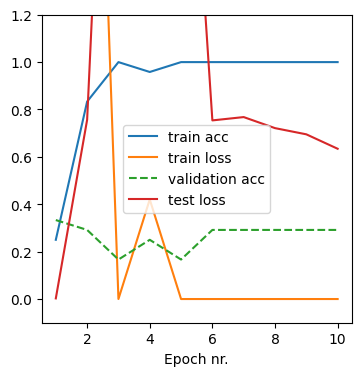

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
epochs = [i+1 for i in range(len(train_accuracies))]
ax.plot(epochs,train_accuracies,label="train acc")
ax.plot(epochs,train_losses,label="train loss")
ax.plot(epochs,validation_accuracies,ls='--',label="validation acc")
ax.plot(epochs,validation_losses,label="test loss")
ax.set_ylim(-0.1,1.2)
ax.set_xlabel("Epoch nr.")
ax.legend()
plt.show()